# Imports

In [1]:
import string
import sys
from collections import deque

import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB

import kaggle

import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Basic Data Analysis

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df.set_index("PassengerId", inplace=True)
train_df = shuffle(train_df)

# Convert the values of numeric column into absolute values
train_df.loc[
    :, ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
] = train_df.loc[
    :, ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].abs()
train_df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
5250_01,Mars,True,F/1007/S,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,0.0,0.0,Clek Dan,True
4137_01,Earth,False,F/778/S,55 Cancri e,39.0,False,664.0,0.0,0.0,40.0,0.0,Lonna Rocknight,False
1147_01,Europa,True,B/42/P,TRAPPIST-1e,49.0,False,0.0,0.0,0.0,0.0,0.0,Solam Semageary,True
0320_01,Earth,False,G/44/S,TRAPPIST-1e,18.0,False,0.0,2.0,0.0,NaN,0.0,Breney Bellarkerd,False
7830_03,Earth,False,G/1268/S,TRAPPIST-1e,46.0,False,0.0,NaN,0.0,17.0,655.0,Willah Belley,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5387_01,Mars,False,D/171/P,TRAPPIST-1e,48.0,False,581.0,6.0,1.0,158.0,0.0,Guanch Ste,False
6006_01,Europa,False,D/190/P,55 Cancri e,45.0,True,1017.0,3863.0,0.0,601.0,3999.0,Okulam Monpreery,False
1850_02,Earth,False,F/356/S,55 Cancri e,25.0,False,0.0,0.0,1.0,735.0,25.0,Leene Schwardson,False


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 5250_01 to 1993_01
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [5]:
train_df.isna().sum()/8693   # percentage of null

HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

# Data Wrangling & EDA

#### 1. Create new columns for missing data and perform EDA on missing items

In [6]:
train_df["HomePlanet_missing"] = train_df["HomePlanet"].isna()
train_df["CryoSleep_missing"] = train_df["CryoSleep"].isna()
train_df["Cabin_missing"] = train_df["Cabin"].isna()
train_df["Destination_missing"] = train_df["Destination"].isna()
train_df["Age_missing"] = train_df["Age"].isna()
train_df["VIP_missing"] = train_df["VIP"].isna()
train_df["RoomService_missing"] = train_df["RoomService"].isna()
train_df["FoodCourt_missing"] = train_df["FoodCourt"].isna()
train_df["ShoppingMall_missing"] = train_df["ShoppingMall"].isna()
train_df["Spa_missing"] = train_df["Spa"].isna()
train_df["VRDeck_missing"] = train_df["VRDeck"].isna()
train_df["Name_missing"] = train_df["Name"].isna()

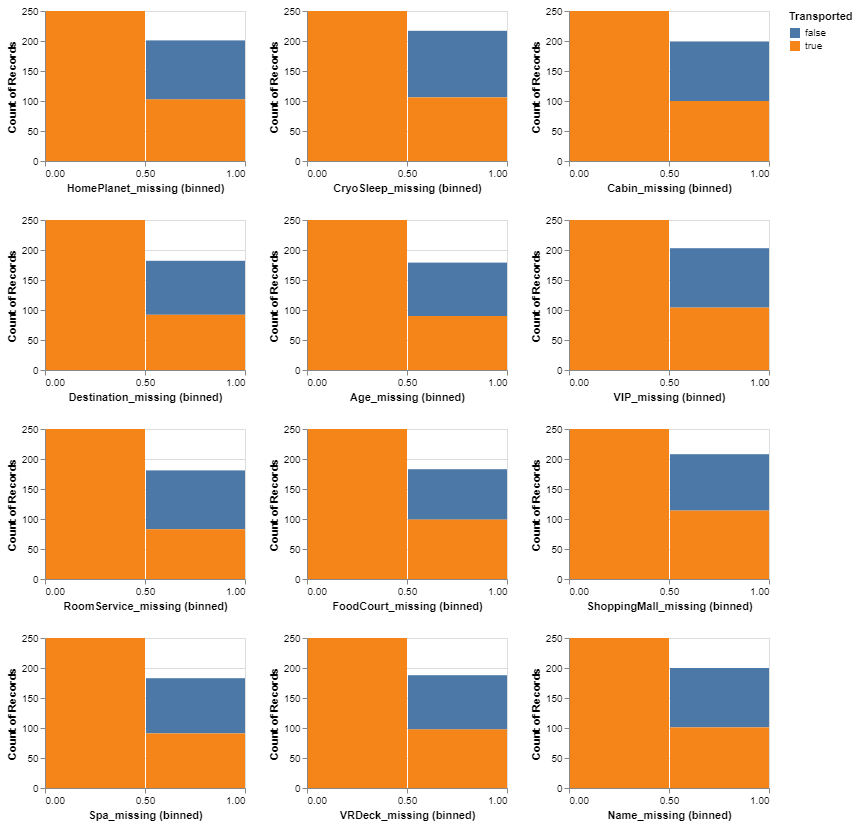

In [7]:
alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=2)),
    alt.Y('count()', scale=alt.Scale(domain=(0, 250))),
    fill='Transported'
).properties(
    width=200,
    height=150
).repeat(
    ["HomePlanet_missing", "CryoSleep_missing", "Cabin_missing",
     "Destination_missing", "Age_missing", "VIP_missing", "RoomService_missing",
     "FoodCourt_missing", "ShoppingMall_missing",
     "Spa_missing", "VRDeck_missing", "Name_missing"],
    columns=3
)

#### 2. Imputation

In [8]:
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")

In [9]:
cat_columns = train_df.columns.tolist()
cat_columns.remove('Transported')
cat_columns.remove('Age')
cat_columns.remove('Name')
cat_columns

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'HomePlanet_missing',
 'CryoSleep_missing',
 'Cabin_missing',
 'Destination_missing',
 'Age_missing',
 'VIP_missing',
 'RoomService_missing',
 'FoodCourt_missing',
 'ShoppingMall_missing',
 'Spa_missing',
 'VRDeck_missing',
 'Name_missing']

In [10]:
train_df.loc[:, ["Age"]] = num_imputer.fit_transform(train_df.loc[:, ["Age"]])
train_df.loc[:, cat_columns] = cat_imputer.fit_transform(train_df.loc[:, cat_columns])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 5250_01 to 1993_01
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HomePlanet            8693 non-null   object 
 1   CryoSleep             8693 non-null   bool   
 2   Cabin                 8693 non-null   object 
 3   Destination           8693 non-null   object 
 4   Age                   8693 non-null   float64
 5   VIP                   8693 non-null   bool   
 6   RoomService           8693 non-null   float64
 7   FoodCourt             8693 non-null   float64
 8   ShoppingMall          8693 non-null   float64
 9   Spa                   8693 non-null   float64
 10  VRDeck                8693 non-null   float64
 11  Name                  8493 non-null   object 
 12  Transported           8693 non-null   bool   
 13  HomePlanet_missing    8693 non-null   bool   
 14  CryoSleep_missing     8693 non-null   bool   
 15  Cabin_missing    

#### 3. Categorical Variables

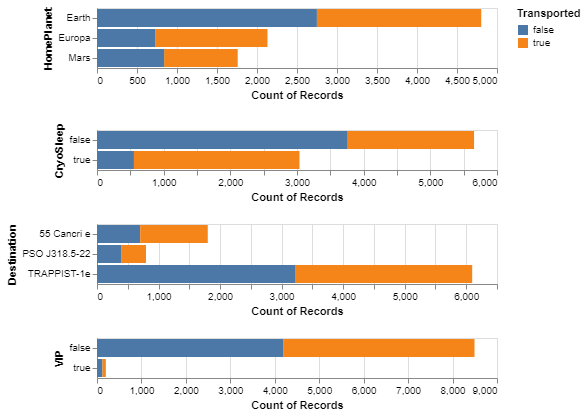

In [11]:
# Perform EDA

plot_homeplanet = alt.Chart(train_df).mark_bar().encode(
    y="HomePlanet",
    x='count()',
    fill='Transported'
)
plot_cryosleep = alt.Chart(train_df).mark_bar().encode(
    y="CryoSleep",
    x='count()',
    fill='Transported'
)
plot_destination = alt.Chart(train_df).mark_bar().encode(
    y="Destination",
    x='count()',
    fill='Transported'
)
plot_vip = alt.Chart(train_df).mark_bar().encode(
    y="VIP",
    x='count()',
    fill='Transported'
)

plot_homeplanet & plot_cryosleep & plot_destination & plot_vip

#### 4. Wrangling on `Cabin`

In [12]:
# Divide Cabin in to sub 3 section

train_df[['Cabin_dec', 'Cabin_num', 'Cabin_side']] = train_df["Cabin"].str.split("/", expand=True)

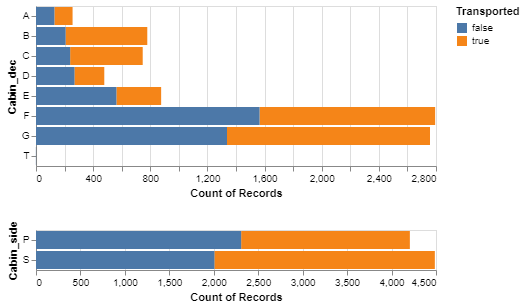

In [13]:
# Perform EDA

plot_cabin_dec = alt.Chart(train_df).mark_bar().encode(
    y="Cabin_dec",
    x='count()',
    fill='Transported'
)
plot_cabin_side = alt.Chart(train_df).mark_bar().encode(
    y="Cabin_side",
    x='count()',
    fill='Transported'
)

plot_cabin_dec & plot_cabin_side

#### 5. Wrangling on `Age`

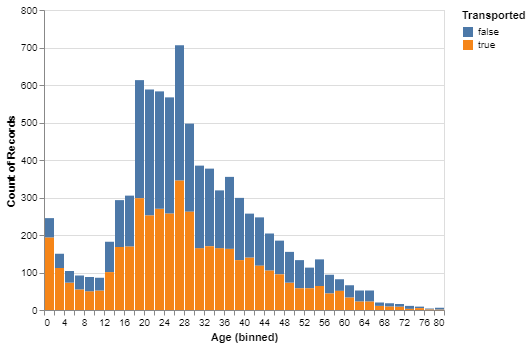

In [14]:
age_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('Age', bin=alt.Bin(maxbins=40)), 
    y='count()',
    fill='Transported')
age_histogram

In [15]:
# Create Age groups
train_df['Age_bin'] = pd.cut(
    train_df['Age'], 
    bins=[-0.1, 12, 18, 30, 50, 66, 90], 
    labels=['Children', 'Teenage', '20s', '30-40s', '50-60s', 'Elder']
)

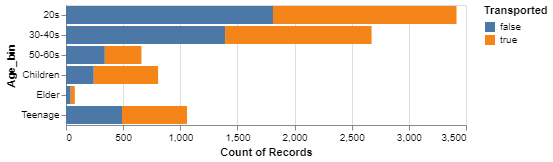

In [16]:
# Perform EDA

plot_age_bin = alt.Chart(train_df).mark_bar().encode(
    y="Age_bin",
    x='count()',
    fill='Transported'
)
plot_age_bin

#### 6. Wrangling on `RoomService`

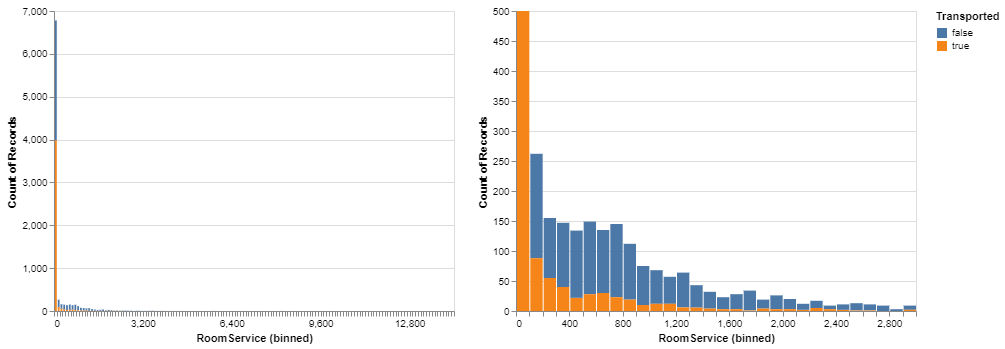

In [17]:
roomservice_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('RoomService', bin=alt.Bin(maxbins=200)), 
    y='count()',
    fill='Transported')
roomservice_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('RoomService', bin=alt.Bin(maxbins=200), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')

roomservice_histogram | roomservice_histogram2

In [18]:
# Create RoomService groups

train_df['RoomService_bin'] = pd.cut(
    train_df['RoomService'], 
    bins=[-0.1, 0.001, 100, 200, 400, 900, 2400, 15000], 
    labels=['RS$0', 'RS$0-100', 'RS$100-200', 'RS$200-400', 'RS$400-900', 'RS$900-2400', 'RS$2400-15000']
)

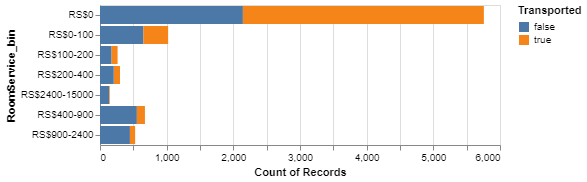

In [19]:
# Perform EDA

plot_roomservice_bin = alt.Chart(train_df).mark_bar().encode(
    y="RoomService_bin",
    x='count()',
    fill='Transported'
)
plot_roomservice_bin

#### 7. Wrangling on `FoodCourt`

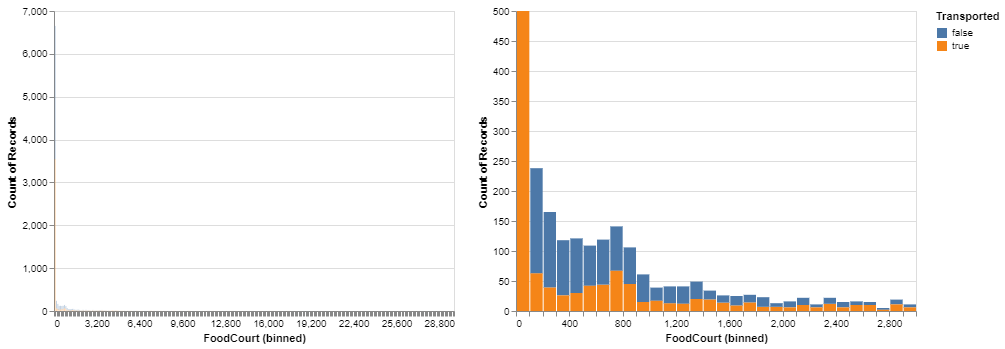

In [20]:
foodcourt_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('FoodCourt', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
foodcourt_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('FoodCourt', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
foodcourt_histogram | foodcourt_histogram2

In [21]:
# Create FoodCourt groups

train_df['FoodCourt_bin'] = pd.cut(
    train_df['FoodCourt'], 
    bins=[-0.1, 0.001, 100, 500, 900, 2000, 30000], 
    labels=['FC$0', 'FC$0-100', 'FC$100-500', 'FC$500-900', 'FC$900-2000', 'FC$2000-30000']
)

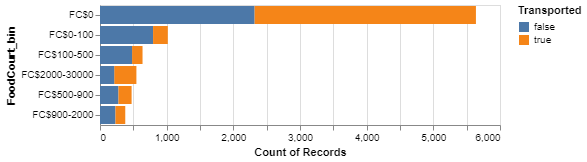

In [22]:
# Perform EDA

plot_roomservice_bin = alt.Chart(train_df).mark_bar().encode(
    y="FoodCourt_bin",
    x='count()',
    fill='Transported'
)
plot_roomservice_bin

#### 8. Wrangling on `ShoppingMall`

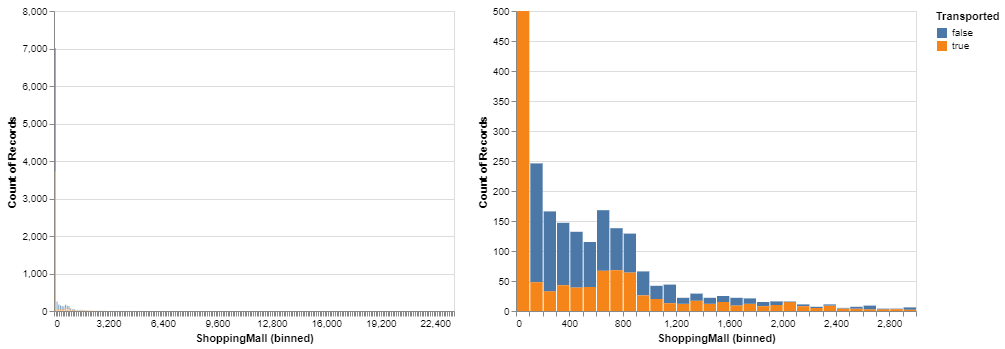

In [23]:
shoppingmall_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('ShoppingMall', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
shoppingmall_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('ShoppingMall', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
shoppingmall_histogram | shoppingmall_histogram2

In [24]:
# Create ShoppingMall groups

train_df['ShoppingMall_bin'] = pd.cut(
    train_df['ShoppingMall'], 
    bins=[-0.1, 0.001, 100, 200, 600, 1200, 2000, 30000], 
    labels=['SM$0', 'SM$0-100', 'SM$100-200', 'SM$200-600', 'SM$600-1200', 'SM$1200-2000', 'SM$2000-30000']
)

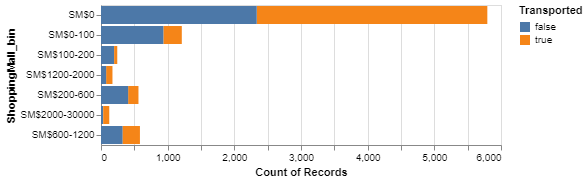

In [25]:
# Perform EDA

plot_shoppingmall_bin = alt.Chart(train_df).mark_bar().encode(
    y="ShoppingMall_bin",
    x='count()',
    fill='Transported'
)
plot_shoppingmall_bin

#### 9. Wrangling on `Spa`

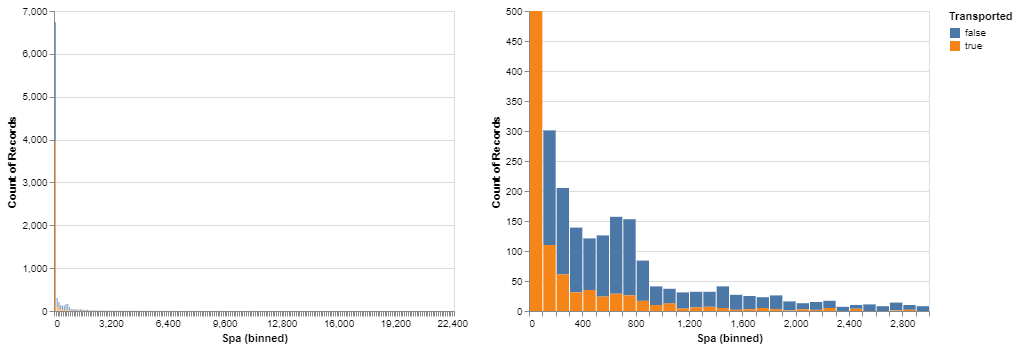

In [26]:
spa_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('Spa', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
spa_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('Spa', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
spa_histogram | spa_histogram2

In [27]:
# Create Spa groups

train_df['Spa_bin'] = pd.cut(
    train_df['Spa'], 
    bins=[-0.1, 0.001, 100, 200, 600, 1200, 2000, 30000], 
    labels=['Sp$0', 'Sp$0-100', 'Sp$100-200', 'Sp$200-600', 'Sp$600-1200', 'Sp$1200-2000', 'Sp$2000-30000']
)

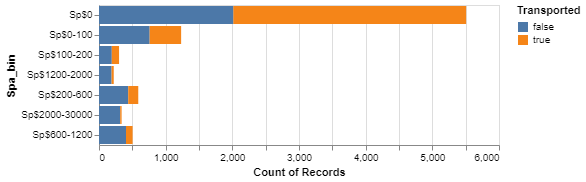

In [28]:
# Perform EDA

plot_spa_bin = alt.Chart(train_df).mark_bar().encode(
    y="Spa_bin",
    x='count()',
    fill='Transported'
)
plot_spa_bin

#### 10. Wrangling on `VRDeck`

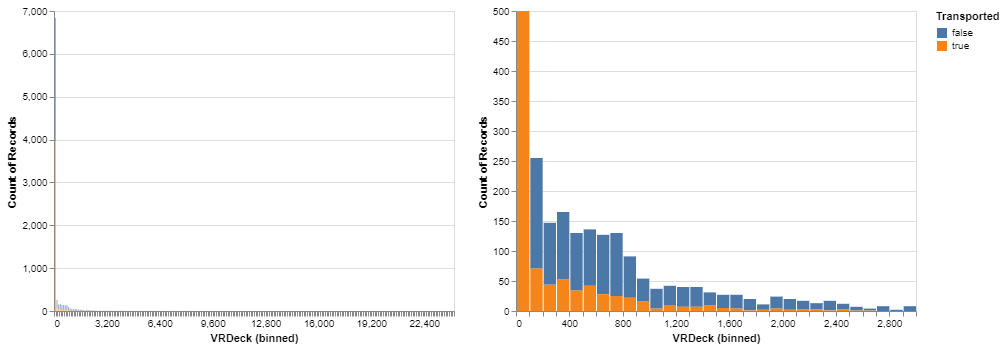

In [29]:
vrdeck_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('VRDeck', bin=alt.Bin(maxbins=400)), 
    y='count()',
    fill='Transported')
vrdeck_histogram2 = alt.Chart(train_df).mark_bar(clip=True).encode(
    alt.X('VRDeck', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 3000))), 
    alt.Y('count()', scale=alt.Scale(domain=(0, 500))),
    fill='Transported')
vrdeck_histogram | vrdeck_histogram2

In [30]:
# Create VRDeck groups

train_df['VRDeck_bin'] = pd.cut(
    train_df['VRDeck'], 
    bins=[-0.1, 0.001, 100, 200, 600, 1000, 2000, 30000], 
    labels=['VR$0', 'VR$0-100', 'VR$100-200', 'VR$200-600', 'VR$600-1000', 'VR$1000-2000', 'VR$2000-30000']
)

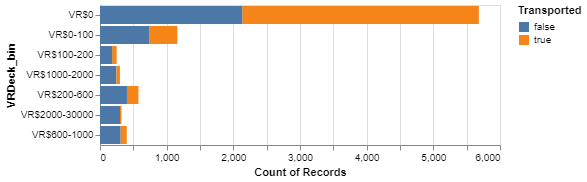

In [31]:
# Perform EDA

plot_vrdeck_bin = alt.Chart(train_df).mark_bar().encode(
    y="VRDeck_bin",
    x='count()',
    fill='Transported'
)
plot_vrdeck_bin

#### 11. Wrangling on `Name`

In [32]:
train_df["Name"].nunique()

8473

In [33]:
# Split `Name` into first and last names

train_df[['Name_first', 'Name_last']] = train_df["Name"].str.split(" ", expand=True)

In [34]:
train_df["Name_first"].nunique()

2706

In [35]:
train_df["Name_last"].nunique()

2217

In [36]:
train_df["Name_last"].value_counts()

Casonston      18
Oneiles        16
Litthews       15
Domington      15
Garnes         14
               ..
Craftstens      1
Bara            1
Estevesters     1
Quith           1
Sacle           1
Name: Name_last, Length: 2217, dtype: int64

In [37]:
# Makes a dictionary using the last name and the number of corresponding last names

num_last_name = train_df["Name_last"].value_counts()
last_name_dict = dict(num_last_name)

In [38]:
# Create separate column with the number of the corresponding last names

for name, num in last_name_dict.items():
    train_df.loc[train_df["Name_last"] == name, "num_of_Name_last"] = num

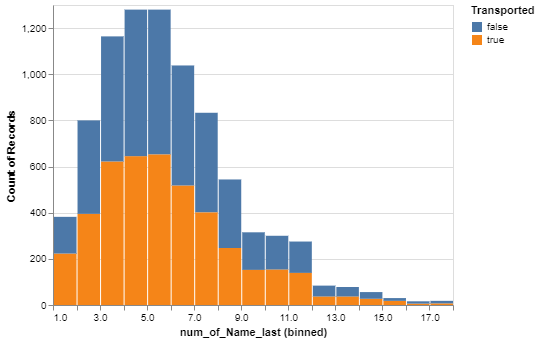

In [39]:
lastname_histogram = alt.Chart(train_df).mark_bar().encode(
    alt.X('num_of_Name_last', bin=alt.Bin(maxbins=20)), 
    y='count()',
    fill='Transported')
lastname_histogram

In [40]:
train_df["num_of_Name_last"].isna().sum()

200

In [41]:
# Impute the missing names

train_df["num_of_Name_last"] = train_df["num_of_Name_last"].fillna(1)

In [42]:
# Create groups for number of last name

train_df['num_of_Name_last'] = pd.cut(
    train_df['num_of_Name_last'], 
    bins=[-100, 1.001, 15, 20], 
    labels=['fam1', 'fam2-15', 'fam15-20']
)

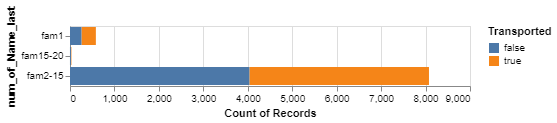

In [43]:
# Perform EDA

plot_num_lastname = alt.Chart(train_df).mark_bar().encode(
    y="num_of_Name_last",
    x='count()',
    fill='Transported'
)
plot_num_lastname

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 5250_01 to 1993_01
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   HomePlanet            8693 non-null   object  
 1   CryoSleep             8693 non-null   bool    
 2   Cabin                 8693 non-null   object  
 3   Destination           8693 non-null   object  
 4   Age                   8693 non-null   float64 
 5   VIP                   8693 non-null   bool    
 6   RoomService           8693 non-null   float64 
 7   FoodCourt             8693 non-null   float64 
 8   ShoppingMall          8693 non-null   float64 
 9   Spa                   8693 non-null   float64 
 10  VRDeck                8693 non-null   float64 
 11  Name                  8493 non-null   object  
 12  Transported           8693 non-null   bool    
 13  HomePlanet_missing    8693 non-null   bool    
 14  CryoSleep_missing     8693 non-null   bool    
 15  

In [45]:
X_train, y_train = train_df.drop(columns=['Transported']), train_df['Transported']

In [46]:
y_train = y_train.astype(int)

# Feature Selection

In [47]:
binary_features = ["HomePlanet_missing", "CryoSleep_missing", "Cabin_missing",
                   "Destination_missing", "Age_missing", "VIP_missing",
                   "RoomService_missing", "FoodCourt_missing", "ShoppingMall_missing",
                   "Spa_missing", "VRDeck_missing", "Name_missing"]

ordinal_age_features = ["Age_bin"]
ordinal_age_order = [
    ['unknown', 'Children', 'Teenage', '20s', '30-40s', '50-60s', 'Elder']
]

ordinal_roomservice_features = ["RoomService_bin"]
ordinal_roomservice_order = [
    ['unknown', 'RS$0', 'RS$0-100', 'RS$100-200', 'RS$200-400', 'RS$400-900', 'RS$900-2400', 'RS$2400-15000']
]

ordinal_foodcourt_features = ["FoodCourt_bin"]
ordinal_foodcourt_order = [
    ['unknown', 'FC$0', 'FC$0-100', 'FC$100-500', 'FC$500-900', 'FC$900-2000', 'FC$2000-30000']
]

ordinal_shoppingmall_features = ["ShoppingMall_bin"]
ordinal_shoppingmall_order = [
    ['unknown', 'SM$0', 'SM$0-100', 'SM$100-200', 'SM$200-600', 'SM$600-1200', 'SM$1200-2000', 'SM$2000-30000']
]

ordinal_spa_features = ["Spa_bin"]
ordinal_spa_order = [
    ['unknown', 'Sp$0', 'Sp$0-100', 'Sp$100-200', 'Sp$200-600', 'Sp$600-1200', 'Sp$1200-2000', 'Sp$2000-30000']
]

ordinal_vrdeck_features = ["VRDeck_bin"]
ordinal_vrdeck_order = [
    ['unknown', 'VR$0', 'VR$0-100', 'VR$100-200', 'VR$200-600', 'VR$600-1000', 'VR$1000-2000', 'VR$2000-30000']
]

ordinal_numlastname_features = ["num_of_Name_last"]
ordinal_numlastname_order = [
    ['unknown', 'fam1', 'fam2-15', 'fam15-20']
]

categorical_features = ["HomePlanet", "CryoSleep", "Destination", "VIP",
                        "Cabin_dec", "Cabin_side"]

drop_features = ["Cabin", "Age", "RoomService", "FoodCourt", "ShoppingMall",
                 "Spa", "VRDeck", "Name", "Cabin_num", "Name_first",
                 "Name_last"]

In [48]:
ct = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary", dtype=int, sparse=False, handle_unknown="ignore"), 
        binary_features
    ),
    (
        OrdinalEncoder(categories=ordinal_age_order),
        ordinal_age_features
    ),
    (
        OrdinalEncoder(categories=ordinal_roomservice_order),
        ordinal_roomservice_features
    ),
    (
        OrdinalEncoder(categories=ordinal_foodcourt_order),
        ordinal_foodcourt_features
    ),
    (
        OrdinalEncoder(categories=ordinal_shoppingmall_order),
        ordinal_shoppingmall_features
    ),
    (
        OrdinalEncoder(categories=ordinal_spa_order),
        ordinal_spa_features
    ),
    (
        OrdinalEncoder(categories=ordinal_vrdeck_order),
        ordinal_vrdeck_features
    ),
    (
        OrdinalEncoder(categories=ordinal_numlastname_order),
        ordinal_numlastname_features
    ),
    (
        make_pipeline(
            OneHotEncoder(handle_unknown="ignore")
        ), categorical_features
    ),
    ("drop", drop_features)
)

# Machine Learning

#### 1. Baseline Model

In [49]:
# To prevent errors

X_train["HomePlanet"] = X_train["HomePlanet"].astype(str)
X_train["CryoSleep"] = X_train["CryoSleep"].astype(str)
X_train["Destination"] = X_train["Destination"].astype(str)
X_train["VIP"] = X_train["VIP"].astype(str)
X_train["Cabin_dec"] = X_train["Cabin_dec"].astype(str)
X_train["Cabin_side"] = X_train["Cabin_side"].astype(str)

In [50]:
results = {}

In [51]:
pipe_dummy = make_pipeline(ct, DummyClassifier())

In [52]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True
)

In [53]:
pd.DataFrame(results)

,Dummy
fit_time,0.051 (+/- 0.018)
score_time,0.017 (+/- 0.002)
test_score,0.504 (+/- 0.000)
train_score,0.504 (+/- 0.000)


#### 2. Various ML Models

In [54]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=2000, random_state=123))
pipe_nb = make_pipeline(ct, MultinomialNB())
pipe_svc = make_pipeline(ct, SVC(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(ct, XGBClassifier(random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_catb = make_pipeline(ct, CatBoostClassifier(random_state=123, verbose=0))

In [55]:
models = {
    "decision_tree": pipe_dt,
    "logistic_regression": pipe_lr,
    "naive_bayes": pipe_nb,
    "SVC": pipe_svc,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb
}

In [56]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True
    )

C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:88

In [57]:
pd.DataFrame(results)

,Dummy,decision_tree,logistic_regression,naive_bayes,SVC,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.051 (+/- 0.018),0.061 (+/- 0.002),0.168 (+/- 0.018),0.048 (+/- 0.005),1.480 (+/- 0.041),0.525 (+/- 0.019),0.318 (+/- 0.019),0.136 (+/- 0.007),3.808 (+/- 0.201)
score_time,0.017 (+/- 0.002),0.015 (+/- 0.001),0.018 (+/- 0.003),0.017 (+/- 0.001),0.579 (+/- 0.012),0.046 (+/- 0.001),0.025 (+/- 0.001),0.026 (+/- 0.001),0.034 (+/- 0.003)
test_score,0.504 (+/- 0.000),0.737 (+/- 0.011),0.791 (+/- 0.011),0.755 (+/- 0.008),0.797 (+/- 0.012),0.782 (+/- 0.006),0.794 (+/- 0.013),0.799 (+/- 0.010),0.800 (+/- 0.008)
train_score,0.504 (+/- 0.000),0.931 (+/- 0.001),0.793 (+/- 0.003),0.758 (+/- 0.002),0.801 (+/- 0.002),0.931 (+/- 0.001),0.866 (+/- 0.005),0.840 (+/- 0.004),0.850 (+/- 0.003)


# Feature Importance

In [58]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['HomePlanet_missing',
                                                   'CryoSleep_missing',
                                                   'Cabin_missing',
                                                   'Destination_missing',
                                                   'Age_missing', 'VIP_missing',
                                                   'RoomService_missing',
                                                   'FoodCourt_missing',
                                              

In [59]:
categorical_columns = pipe_lr.named_steps["columntransformer"].named_transformers_["pipeline"].named_steps["onehotencoder"].get_feature_names_out(categorical_features).tolist()

In [60]:
columns = (binary_features + ordinal_age_features + ordinal_roomservice_features + ordinal_foodcourt_features +
           ordinal_shoppingmall_features + ordinal_spa_features + ordinal_vrdeck_features +
           ordinal_numlastname_features + categorical_columns)

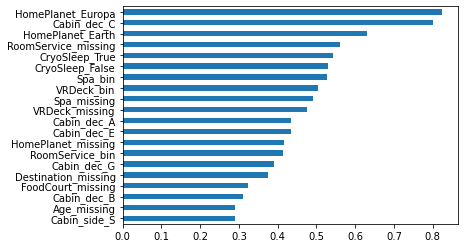

In [61]:
top20_lr = pd.Series(abs(pipe_lr.named_steps["logisticregression"].coef_.flatten()), columns).sort_values(ascending=False).head(20)
top20_lr.plot.barh().invert_yaxis()
plt.show();

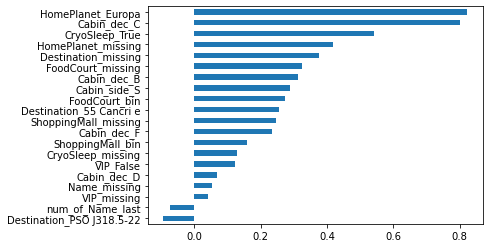

In [62]:
top20_lr = pd.Series((pipe_lr.named_steps["logisticregression"].coef_.flatten()), columns).sort_values(ascending=False).head(20)
top20_lr.plot.barh().invert_yaxis()
plt.show();

# Test Set Preparation

#### 1. Basic Analysis

In [63]:
X_test = pd.read_csv("data/test.csv")

# Convert the values of numeric column into absolute values
X_test.loc[
    :, ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
] = X_test.loc[
    :, ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].abs()
X_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [64]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [65]:
X_test.isna().sum()/4277

PassengerId     0.000000
HomePlanet      0.020341
CryoSleep       0.021744
Cabin           0.023381
Destination     0.021510
Age             0.021277
VIP             0.021744
RoomService     0.019172
FoodCourt       0.024784
ShoppingMall    0.022913
Spa             0.023615
VRDeck          0.018705
Name            0.021978
dtype: float64

#### 2. Data Wrangling

In [66]:
# Make columns for missing data
X_test["HomePlanet_missing"] = X_test["HomePlanet"].isna()
X_test["CryoSleep_missing"] = X_test["CryoSleep"].isna()
X_test["Cabin_missing"] = X_test["Cabin"].isna()
X_test["Destination_missing"] = X_test["Destination"].isna()
X_test["Age_missing"] = X_test["Age"].isna()
X_test["VIP_missing"] = X_test["VIP"].isna()
X_test["RoomService_missing"] = X_test["RoomService"].isna()
X_test["FoodCourt_missing"] = X_test["FoodCourt"].isna()
X_test["ShoppingMall_missing"] = X_test["ShoppingMall"].isna()
X_test["Spa_missing"] = X_test["Spa"].isna()
X_test["VRDeck_missing"] = X_test["VRDeck"].isna()
X_test["Name_missing"] = X_test["Name"].isna()

# Perform imputation
X_test.loc[:, ["Age"]] = num_imputer.fit_transform(X_test.loc[:, ["Age"]])
X_test.loc[:, cat_columns] = cat_imputer.fit_transform(X_test.loc[:, cat_columns])

# Cabin
X_test[['Cabin_dec', 'Cabin_num', 'Cabin_side']] = X_test["Cabin"].str.split("/", expand=True)

# Age
X_test['Age_bin'] = pd.cut(
    X_test['Age'], 
    bins=[-0.1, 12, 18, 30, 50, 66, 90], 
    labels=['Children', 'Teenage', '20s', '30-40s', '50-60s', 'Elder']
)

# RoomService
X_test['RoomService_bin'] = pd.cut(
    X_test['RoomService'], 
    bins=[-0.1, 0.001, 100, 200, 400, 900, 2400, 15000], 
    labels=['RS$0', 'RS$0-100', 'RS$100-200', 'RS$200-400', 'RS$400-900', 'RS$900-2400', 'RS$2400-15000']
)

# FoodCourt
X_test['FoodCourt_bin'] = pd.cut(
    X_test['FoodCourt'], 
    bins=[-0.1, 0.001, 100, 500, 900, 2000, 30000], 
    labels=['FC$0', 'FC$0-100', 'FC$100-500', 'FC$500-900', 'FC$900-2000', 'FC$2000-30000']
)

# ShoppingMall
X_test['ShoppingMall_bin'] = pd.cut(
    X_test['ShoppingMall'], 
    bins=[-0.1, 0.001, 100, 200, 600, 1200, 2000, 30000], 
    labels=['SM$0', 'SM$0-100', 'SM$100-200', 'SM$200-600', 'SM$600-1200', 'SM$1200-2000', 'SM$2000-30000']
)

# Spa
X_test['Spa_bin'] = pd.cut(
    X_test['Spa'], 
    bins=[-0.1, 0.001, 100, 200, 600, 1200, 2000, 30000], 
    labels=['Sp$0', 'Sp$0-100', 'Sp$100-200', 'Sp$200-600', 'Sp$600-1200', 'Sp$1200-2000', 'Sp$2000-30000']
)

# VRDeck
X_test['VRDeck_bin'] = pd.cut(
    X_test['VRDeck'], 
    bins=[-0.1, 0.001, 100, 200, 600, 1000, 2000, 30000], 
    labels=['VR$0', 'VR$0-100', 'VR$100-200', 'VR$200-600', 'VR$600-1000', 'VR$1000-2000', 'VR$2000-30000']
)

# Name
X_test[['Name_first', 'Name_last']] = X_test["Name"].str.split(" ", expand=True)
num_last_name = X_test["Name_last"].value_counts()
last_name_dict = dict(num_last_name)
for name, num in last_name_dict.items():
    X_test.loc[X_test["Name_last"] == name, "num_of_Name_last"] = num

X_test["num_of_Name_last"] = X_test["num_of_Name_last"].fillna(1)
    
X_test['num_of_Name_last'] = pd.cut(
    X_test['num_of_Name_last'], 
    bins=[-100, 1.001, 15, 20], 
    labels=['fam1', 'fam2-15', 'fam15-20']
)

# Change data type to prevent error
X_test["HomePlanet"] = X_test["HomePlanet"].astype(str)
X_test["CryoSleep"] = X_test["CryoSleep"].astype(str)
X_test["Destination"] = X_test["Destination"].astype(str)
X_test["VIP"] = X_test["VIP"].astype(str)
X_test["Cabin_dec"] = X_test["Cabin_dec"].astype(str)
X_test["Cabin_side"] = X_test["Cabin_side"].astype(str)

In [67]:
X_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Cabin_side,Age_bin,RoomService_bin,FoodCourt_bin,ShoppingMall_bin,Spa_bin,VRDeck_bin,Name_first,Name_last,num_of_Name_last
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,S,20s,RS$0,FC$0,SM$0,Sp$0,VR$0,Nelly,Carsoning,fam2-15
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,...,S,20s,RS$0,FC$0-100,SM$0,Sp$2000-30000,VR$0,Lerome,Peckers,fam1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,...,S,30-40s,RS$0,FC$0,SM$0,Sp$0,VR$0,Sabih,Unhearfus,fam1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,...,S,30-40s,RS$0,FC$2000-30000,SM$0,Sp$100-200,VR$200-600,Meratz,Caltilter,fam1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,...,S,20s,RS$0-100,FC$0,SM$600-1200,Sp$0,VR$0,Brence,Harperez,fam2-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,...,S,30-40s,RS$0,FC$0,SM$0,Sp$0,VR$0,Jeron,Peter,fam2-15
4273,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,...,P,30-40s,RS$0,FC$500-900,SM$0-100,Sp$0-100,VR$100-200,Matty,Scheron,fam2-15
4274,9271_01,Mars,True,D/296/P,55 Cancri e,26.0,False,0.0,0.0,0.0,...,P,20s,RS$0,FC$0,SM$0,Sp$0,VR$0,Jayrin,Pore,fam2-15
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,26.0,False,0.0,2680.0,0.0,...,P,20s,RS$0,FC$2000-30000,SM$0,Sp$0,VR$200-600,Kitakan,Conale,fam2-15


In [68]:
prediction = {}

In [69]:
for (name, model) in models.items():
    model.fit(X_train, y_train)
    prediction[name] = model.predict(X_test)

C:\Users\johnw\miniconda3\envs\573\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [70]:
predictions = pd.DataFrame(prediction).astype(bool)

In [71]:
for name in models.keys():
    temp_df = X_test
    temp_df["Transported"] = predictions[name]
    temp_df = temp_df.loc[:, ["PassengerId", "Transported"]]
    temp_df.to_csv(f"results_imp/spaceship_titanic_imputation_220403_{name}.csv", encoding='utf-8', index=False)

# Ensemble

In [72]:
ensemble_pred = pd.DataFrame(prediction)
ensemble_pred["ensemble"] = ensemble_pred.mean(axis=1)
ensemble_pred.loc[ensemble_pred["ensemble"] >= 0.5, "ensemble"] = 1
ensemble_pred.loc[ensemble_pred["ensemble"] < 0.5, "ensemble"] = 0 
ensemble_pred

,decision_tree,logistic_regression,naive_bayes,SVC,random_forest,XGBoost,LightGBM,CatBoost,ensemble
0,1,1,1,1,1,1,1,1,1.0
1,0,0,0,0,0,0,0,0,0.0
2,1,1,1,1,1,1,1,1,1.0
3,0,1,1,1,1,1,1,1,1.0
4,1,1,0,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...,...
4272,1,1,1,1,1,1,1,1,1.0
4273,0,0,0,0,0,0,0,0,0.0
4274,1,1,1,1,1,1,1,1,1.0
4275,1,1,0,1,1,1,1,1,1.0


In [73]:
temp_df = X_test
temp_df["Transported"] = ensemble_pred["ensemble"].astype(bool)
temp_df = temp_df.loc[:, ["PassengerId", "Transported"]]
temp_df.to_csv("results_imp/spaceship_titanic_imputation_220403_ensemble.csv", encoding='utf-8', index=False)